# Final Ground Model with Optuna (MLP, LSTM, BiLSTM, CNN-LSTM, Transformer)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2025-11-19 21:53:43.203647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 21:53:43.209558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763607223.216139 1070317 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763607223.218405 1070317 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-19 21:53:43.226365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Config

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = Path("../data_processed")
OUT_DIR  = Path("../reports/skill_heatmaps_ground")
OUT_DIR.mkdir(parents=True, exist_ok=True)

H_LIST = [6, 18, 36] 

print("Output dir:", OUT_DIR.resolve())

Output dir: /mnt/SOLARLAB/E_Ladino/Repo/irradiance-fusion-forecast/reports/skill_heatmaps_ground


## Helpers

In [3]:
def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def skill(y_true, y_pred, y_base):
    return 1.0 - (_rmse(y_true, y_pred) / (_rmse(y_true, y_base) + 1e-6))

def build_simple_mlp(input_dim: int):
    """
    MLP fijo (sin Optuna) para todos los horizontes.
    Si luego quieres cambiar arquitectura, solo tocas aquí.
    """
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, dtype="float32"),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"],
    )
    return model

def hourly_skill(y_true, y_pred, y_base, idx):
    """
    Skill vs persistencia por hora del día:
    skill(h) = 1 - RMSE_model(h) / RMSE_base(h).
    """
    df = pd.DataFrame({
        "time": idx,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_base": y_base,
    }).set_index("time")
    df["hour"] = df.index.hour

    rows = []
    for h in range(24):
        sub = df[df["hour"] == h]
        if len(sub) < 10:  # pocas muestras → skip
            continue
        rmse_m = _rmse(sub["y_true"], sub["y_pred"])
        rmse_b = _rmse(sub["y_true"], sub["y_base"])
        skl = 1.0 - rmse_m / (rmse_b + 1e-6)
        rows.append((h, rmse_m, rmse_b, skl))

    if not rows:
        return pd.DataFrame(columns=["rmse_model", "rmse_base", "skill"])

    res = pd.DataFrame(rows, columns=["hour", "rmse_model", "rmse_base", "skill"]).set_index("hour")
    return res

### Models - Loop

In [4]:
metrics_by_h = {}          # métricas globales por horizonte
hourly_skill_by_h = {}     # DataFrame skill(hora) por horizonte

for H in H_LIST:
    print("\n" + "="*60)
    print(f"=== Horizonte H={H} pasos (≈ {H*10} min) ===")
    print("="*60)

    # ---------- Carga ----------
    train_pq = DATA_DIR / f"ground_train_h{H}.parquet"
    val_pq   = DATA_DIR / f"ground_val_h{H}.parquet"
    test_pq  = DATA_DIR / f"ground_test_h{H}.parquet"

    if not (train_pq.exists() and val_pq.exists() and test_pq.exists()):
        print(f"Faltan parquets para h={H}, se omite.")
        continue

    train = pd.read_parquet(train_pq).sort_index()
    val   = pd.read_parquet(val_pq).sort_index()
    test  = pd.read_parquet(test_pq).sort_index()

    # ---------- Target robusto ----------
    candidatos = [f"y_ghi_h{H}", f"y_k_h{H}", f"y_ghi_sg_h{H}"]
    y_cols = [c for c in train.columns if c.startswith("y_")]
    target = None
    for c in candidatos:
        if c in train.columns:
            target = c
            break
    if target is None:
        posibles = [c for c in y_cols if c.endswith(f"_h{H}")]
        if posibles:
            target = posibles[0]
    if target is None:
        print(f"  → No encontré ningún target y_* para h={H}, se omite.")
        continue

    print("  Target usado:", target)

    # ---------- Features ----------
    # numéricas comunes en train/val/test excepto cualquier y_*
    common_cols = set(train.columns) & set(val.columns) & set(test.columns)
    feat_cols = sorted([
        c for c in common_cols
        if (c != target) and (not c.startswith("y_")) and
           pd.api.types.is_numeric_dtype(train[c])
    ])

    Xtr_df, ytr = train[feat_cols], train[target]
    Xva_df, yva = val[feat_cols],   val[target]
    Xte_df, yte = test[feat_cols],  test[target]

    # ---------- Escalado ----------
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr_df)
    Xva = scaler.transform(Xva_df)
    Xte = scaler.transform(Xte_df)

    # ---------- Baseline (persistencia) ----------
    if target.startswith("y_ghi"):
        base_candidates = ["ghi_qc", "ghi_sg_definitive", "ghi_qc_lag1"]
    else:  # índice k
        base_candidates = ["k_ghi", "k_raw", "k_ghi_lag1", "k_raw_lag1"]

    base_src = None
    for c in base_candidates:
        if c in test.columns:
            base_src = test[c]
            break
    if base_src is None:
        base_src = pd.Series(np.nanmedian(ytr), index=test.index)
        print("  WARNING: baseline degenerada (mediana).")

    y_base = base_src.to_numpy()

    print(f"  Baseline RMSE: {_rmse(yte, y_base):.4f} | MAE: {mean_absolute_error(yte, y_base):.4f}")

    # ---------- Modelo MLP ----------
    model = build_simple_mlp(input_dim=Xtr.shape[1])

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1
    )

    hist = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=100,
        batch_size=256,
        verbose=0,
        callbacks=[es]
    )
    print(f"  Epochs entrenadas: {len(hist.history['loss'])}")

    # ---------- Evaluación en test ----------
    y_pred = model.predict(Xte, verbose=0).squeeze()

    rmse = _rmse(yte, y_pred)
    mae  = mean_absolute_error(yte, y_pred)
    r2   = r2_score(yte, y_pred)
    skl  = skill(yte, y_pred, y_base)

    metrics_by_h[H] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Skill": skl,
        "RMSE_base": _rmse(yte, y_base),
        "MAE_base": mean_absolute_error(yte, y_base),
    }

    print(f"  MODEL Test → RMSE={rmse:.4f} | MAE={mae:.4f} | R2={r2:.4f} | Skill={skl:.3f}")

    # ---------- Skill horario ----------
    sk_hour = hourly_skill(
        y_true=yte,
        y_pred=y_pred,
        y_base=y_base,
        idx=Xte_df.index
    )
    hourly_skill_by_h[H] = sk_hour


=== Horizonte H=6 pasos (≈ 60 min) ===
  Target usado: y_ghi_h6
  Baseline RMSE: 196.2835 | MAE: 102.1871


I0000 00:00:1763607228.195807 1070317 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 291 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1763607229.381798 1071260 service.cc:148] XLA service 0x7a4bd00051a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763607229.381819 1071260 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-11-19 21:53:49.391627: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763607229.435932 1071260 cuda_dnn.cc:529] Loaded cuDNN version 90101
I0000 00:00:1763607229.873124 1071260 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-19 21:53:50.900628: I external/loca

Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 61.
  Epochs entrenadas: 73
  MODEL Test → RMSE=137.1845 | MAE=68.3696 | R2=0.7162 | Skill=0.301

=== Horizonte H=18 pasos (≈ 180 min) ===
  Target usado: y_ghi_h18
  Baseline RMSE: 289.3891 | MAE: 170.2367


2025-11-19 21:54:11.724919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 12 bytes spill stores, 12 bytes spill loads

2025-11-19 21:54:11.761771: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 32 bytes spill stores, 32 bytes spill loads



Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 29.
  Epochs entrenadas: 41
  MODEL Test → RMSE=148.0361 | MAE=77.8766 | R2=0.6696 | Skill=0.488

=== Horizonte H=36 pasos (≈ 360 min) ===
  Target usado: y_ghi_h36
  Baseline RMSE: 386.8405 | MAE: 253.5388


2025-11-19 21:54:26.942193: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 12 bytes spill stores, 12 bytes spill loads

2025-11-19 21:54:27.016737: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 32 bytes spill stores, 32 bytes spill loads



Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 71.
  Epochs entrenadas: 83
  MODEL Test → RMSE=156.1436 | MAE=84.6602 | R2=0.6325 | Skill=0.596


### Summary

In [5]:
if not metrics_by_h:
    raise RuntimeError("No se generaron métricas; revisa H_LIST y los parquets disponibles.")

metrics_df = (
    pd.DataFrame(metrics_by_h)
    .T  # filas = horizonte H
    .rename_axis("H")
    .sort_index()
)

print("\n=== Métricas globales por horizonte (test) ===")
print(metrics_df.round(4))

metrics_path = OUT_DIR / "ground_skill_metrics_by_horizon.csv"
metrics_df.to_csv(metrics_path)
print("Saved metrics →", metrics_path)


=== Métricas globales por horizonte (test) ===
        RMSE      MAE      R2   Skill  RMSE_base  MAE_base
H                                                         
6   137.1845  68.3696  0.7162  0.3011   196.2835  102.1871
18  148.0361  77.8766  0.6696  0.4885   289.3891  170.2367
36  156.1436  84.6602  0.6325  0.5964   386.8405  253.5388
Saved metrics → ../reports/skill_heatmaps_ground/ground_skill_metrics_by_horizon.csv


## Visualization

In [6]:
all_hours = range(24)
horiz_minutes = [H*10 for H in sorted(hourly_skill_by_h.keys())]

heat_mat = pd.DataFrame(
    data=np.nan,
    index=all_hours,
    columns=horiz_minutes,
    dtype="float32"
)

for H, df_sk in hourly_skill_by_h.items():
    col = H*10  # minutos
    for h in df_sk.index:
        heat_mat.loc[h, col] = df_sk.loc[h, "skill"]

heat_path = OUT_DIR / "ground_skill_hour_vs_horizon_matrix.csv"
heat_mat.to_csv(heat_path)
print("Saved heatmap matrix →", heat_path)

/tmp/ipykernel_1070317/4253304026.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.2312686643446646' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  heat_mat.loc[h, col] = df_sk.loc[h, "skill"]
/tmp/ipykernel_1070317/4253304026.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.4190433601837724' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  heat_mat.loc[h, col] = df_sk.loc[h, "skill"]
/tmp/ipykernel_1070317/4253304026.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-9.426529208930361' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  heat_mat.loc[h, col] = df_sk.loc[h, "skill"]


Saved heatmap matrix → ../reports/skill_heatmaps_ground/ground_skill_hour_vs_horizon_matrix.csv


### Plots

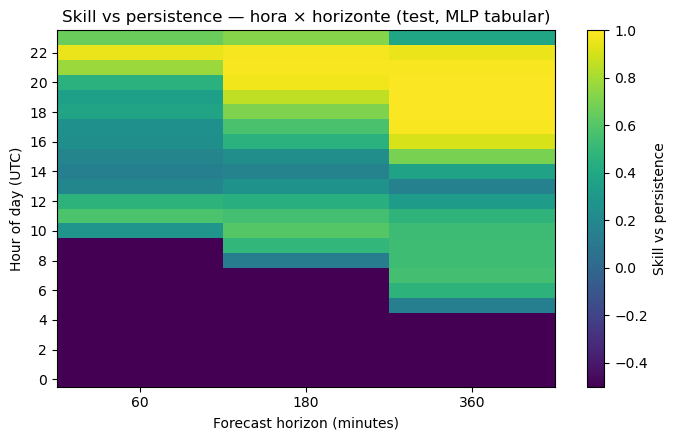

Saved heatmap figure → ../reports/skill_heatmaps_ground/ground_skill_hour_vs_horizon_heatmap.png


In [7]:
plt.figure(figsize=(7, 4.5))
# imshow espera [rows, cols] = [horas, horizontes]
im = plt.imshow(
    heat_mat.values,
    origin="lower",
    aspect="auto",
    vmin=-0.5, vmax=1.0  # rango razonable para skill
)
plt.colorbar(im, label="Skill vs persistence")

plt.yticks(
    ticks=np.arange(0, 24, 2),
    labels=np.arange(0, 24, 2)
)
plt.xticks(
    ticks=np.arange(len(horiz_minutes)),
    labels=horiz_minutes
)

plt.xlabel("Forecast horizon (minutes)")
plt.ylabel("Hour of day (UTC)")
plt.title("Skill vs persistence — hora × horizonte (test, MLP tabular)")
plt.tight_layout()

heat_fig_path = OUT_DIR / "ground_skill_hour_vs_horizon_heatmap.png"
plt.savefig(heat_fig_path, dpi=160)
plt.show()

print("Saved heatmap figure →", heat_fig_path)